In [ ]:
! pip install astroNN

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow import keras


from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout,MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras import utils,Model, Input, regularizers,optimizers

from astroNN.models import Galaxy10CNN
from astroNN.datasets import load_galaxy10sdss
from astroNN.datasets.galaxy10sdss import galaxy10cls_lookup, galaxy10_confusion

import cv2
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
import matplotlib.image as img
from PIL import Image
from tensorflow.keras.applications.vgg16 import preprocess_input,VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')
from tensorflow.keras.applications import ResNet50,EfficientNetB0


# Downloading dataset

In [ ]:
images,labels =load_galaxy10sdss()

/root/.astroNN/datasets/Galaxy10.h5 was found!


In [ ]:
print(labels)

[2 2 4 ... 2 9 2]


# Preprocessing

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)

In [ ]:
features = ['Disk, Face-on, No Spiral', 'Smooth, Completely round', 'Smooth, in-between round', 'Smooth, Cigar shaped', 'Disk, Edge-on, Rounded Bulge', 'Disk, Edge-on, Boxy Bulge',
            'Disk, Edge-on, No Bulge','Disk, Face-on, Tight Spiral', 'Disk, Face-on, Medium Spiral', 'Disk, Face-on, Loose Spiral']

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
x_train.shape, x_test.shape

((17428, 69, 69, 3), (4357, 69, 69, 3))

In [ ]:
# Resize images
x_train = np.array([cv2.resize(img, (32, 32)) for img in x_train])
x_test = np.array([cv2.resize(img, (32, 32)) for img in x_test])

# Make sure img onverted to RGB
x_train = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if len(img.shape) == 2 else img for img in x_train])
x_test = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if len(img.shape) == 2 else img for img in x_test])

# Check the shape
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

# Reshape
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))


x_train shape: (17428, 32, 32, 3), x_test shape: (4357, 32, 32, 3)


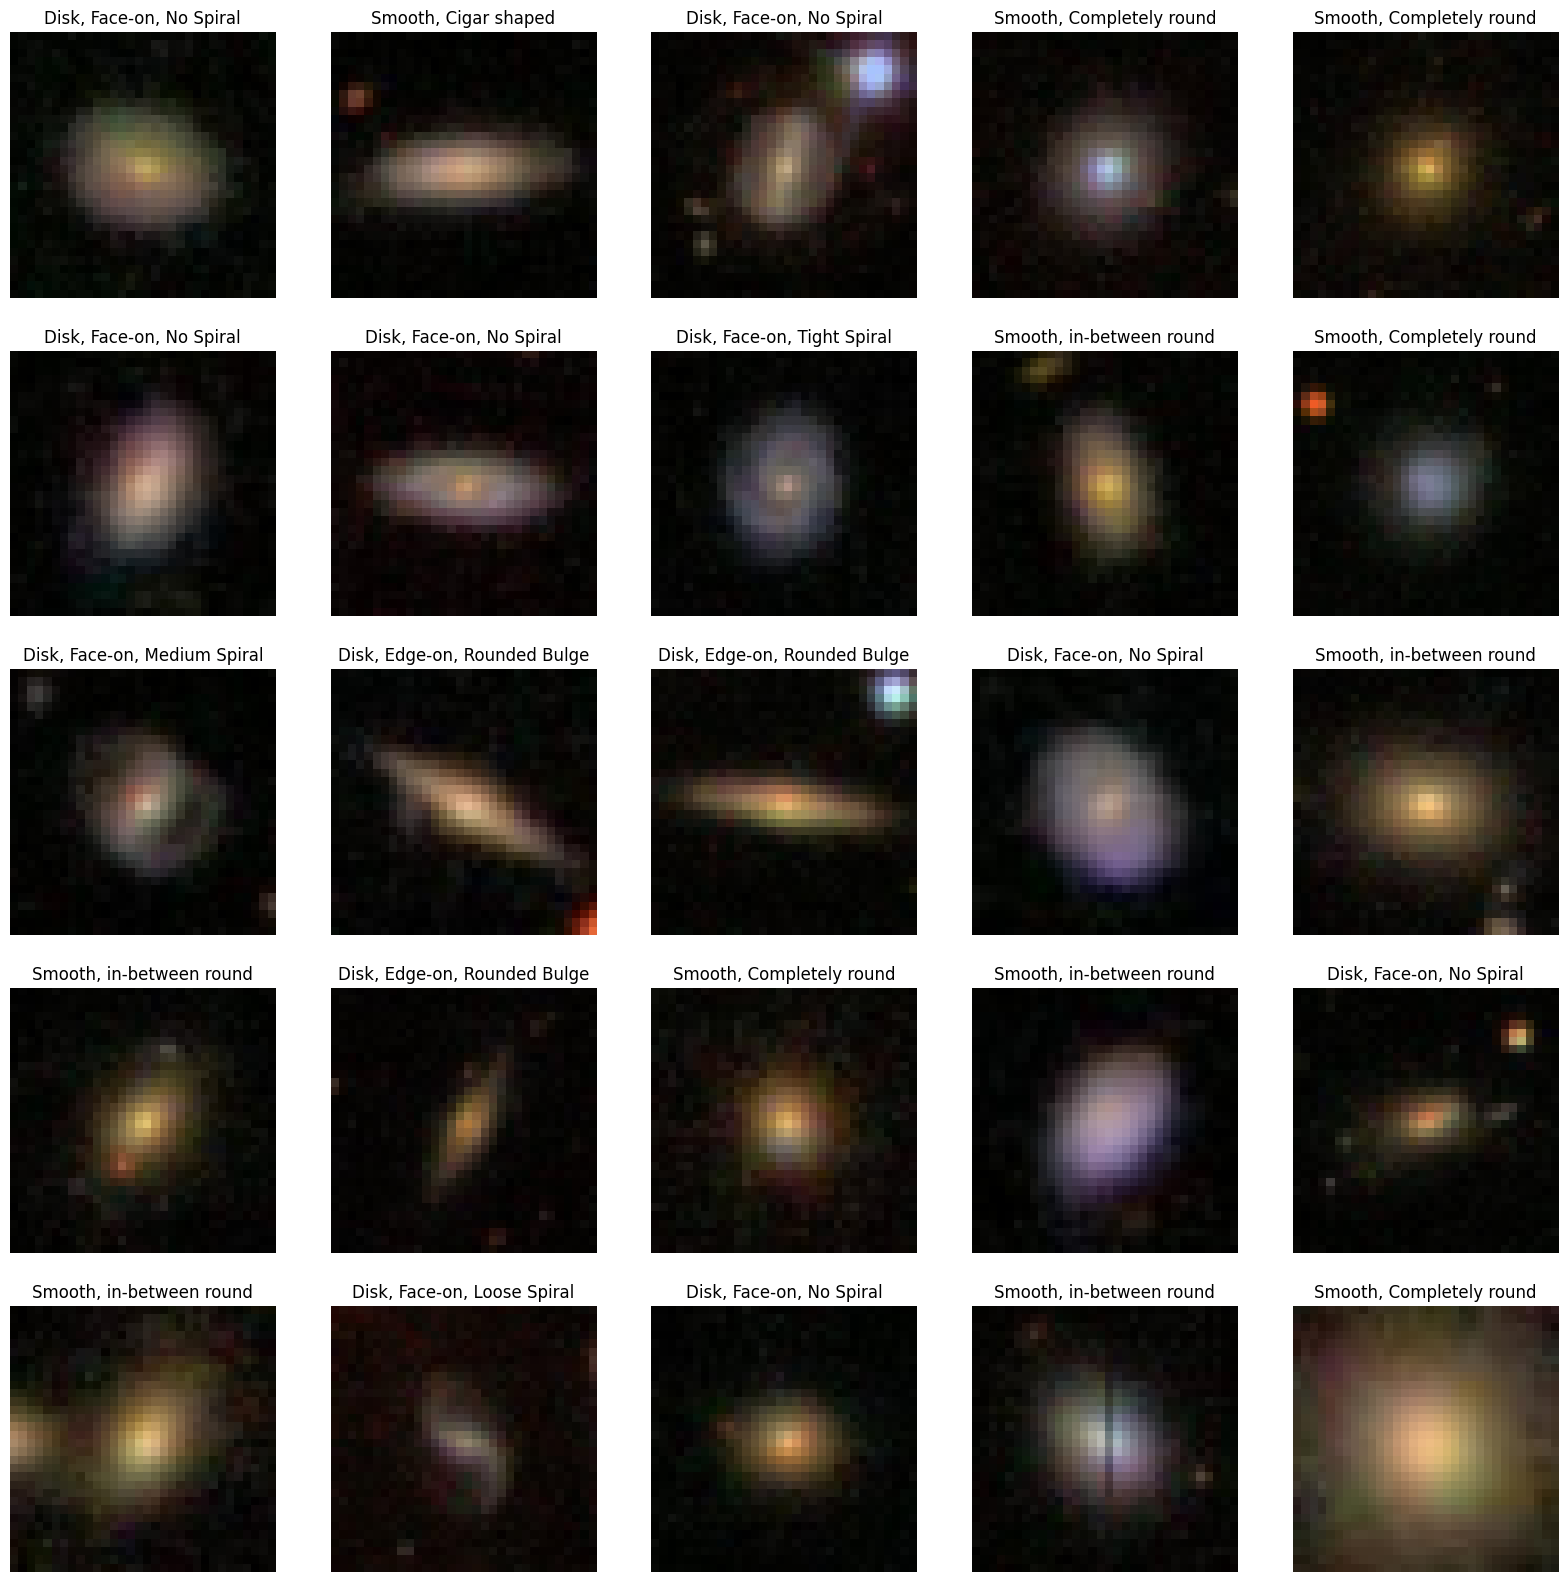

In [ ]:
fig = plt.figure(figsize=(20,20))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[i])
    plt.title(features[y_train[i]])
    plt.axis('off')

plt.show()

In [ ]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
# train Data Augmentation

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip= True,
    fill_mode='nearest')

# test Data Augmentation
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip= True,
    fill_mode='nearest')

In [ ]:
train_set = train_datagen.flow(
    x_train,y_train,
    batch_size=32,
 # Use this subset for training
)

test_set = test_datagen.flow(x_test,y_test,
                                            batch_size = 4,
                                           )


# CNN

In [ ]:


def cnn():
  # Specify model architecture
  model = Sequential()
  # Block 1
  model.add(Conv2D(32, (3, 3),
                  activation='relu',
                  kernel_initializer='he_uniform',
                  padding='same',
                  input_shape=(32, 32, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))
  # Block 2
  model.add(Conv2D(64,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  # FC part
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # Print summary
  model.summary()

  # Compile model
  model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])
  return model

simple_cnn = cnn()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 422,218 (1.61 MB)

 Trainable params: 422,218 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Set the number of epochs
NUM_EPOCHS = 40

# Early stopping callback
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# Train the model using the ImageDataGenerator outputs
history = simple_cnn.fit(x_train, y_train,
                    validation_split = 0.2,
                    callbacks = [earlystop],
                    epochs = NUM_EPOCHS)

Epoch 1/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.3755 - loss: 1.5592 - val_accuracy: 0.4874 - val_loss: 1.3049
Epoch 2/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 32s 60ms/step - accuracy: 0.5714 - loss: 1.0893 - val_accuracy: 0.5921 - val_loss: 1.0369
Epoch 3/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.6491 - loss: 0.9466 - val_accuracy: 0.6692 - val_loss: 0.8579
Epoch 4/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - accuracy: 0.6936 - loss: 0.8236 - val_accuracy: 0.6776 - val_loss: 0.8391
Epoch 5/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 43s 60ms/step - accuracy: 0.7127 - loss: 0.7816 - val_accuracy: 0.7269 - val_loss: 0.7504
Epoch 6/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 45s 70ms/step - accuracy: 0.7288 - loss: 0.7432 - val_accuracy: 0.7088 - val_loss: 0.7783
Epoch 7/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 32s 73ms/step - accuracy: 0.7469 - loss: 0.6919 - val_accuracy: 0.7034 - val_loss: 0.7852
Epoch 8/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 26s 60ms/step - accuracy: 0.7442 - loss: 0.6763 - 

# Deeper cnn

In [ ]:
def deeper_cnn():
  # Specify model architecture
  model = Sequential()
  # Block 1
  model.add(Conv2D(32, (3, 3),
                  activation='relu',
                  kernel_initializer='he_uniform',
                  padding='same',
                  input_shape=(32, 32, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))
  # Block 2
  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
# block 3
  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  # block 4
  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  # FC part
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # Print summary
  model.summary()

  # Compile model
  model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model_deep_cnn = deeper_cnn()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 127,434 (497.79 KB)

 Trainable params: 127,434 (497.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Set the number of epochs
NUM_EPOCHS = 40

# Early stopping callback
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# Train the model using the ImageDataGenerator outputs
history2 = model_deep_cnn.fit(x_train, y_train,
                    validation_split = 0.2,
                    callbacks = [earlystop],
                    epochs = NUM_EPOCHS)

Epoch 1/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 39s 82ms/step - accuracy: 0.3550 - loss: 1.5847 - val_accuracy: 0.4974 - val_loss: 1.2014
Epoch 2/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.5351 - loss: 1.1380 - val_accuracy: 0.6738 - val_loss: 0.9266
Epoch 3/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.6561 - loss: 0.9169 - val_accuracy: 0.6632 - val_loss: 0.8880
Epoch 4/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.6933 - loss: 0.8037 - val_accuracy: 0.7332 - val_loss: 0.7332
Epoch 5/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 35s 80ms/step - accuracy: 0.7303 - loss: 0.7263 - val_accuracy: 0.7450 - val_loss: 0.6977
Epoch 6/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - accuracy: 0.7379 - loss: 0.7134 - val_accuracy: 0.7398 - val_loss: 0.7031
Epoch 7/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.7431 - loss: 0.6765 - val_accuracy: 0.7470 - val_loss: 0.6630
Epoch 8/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.7605 - loss: 0.6357 - 

137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


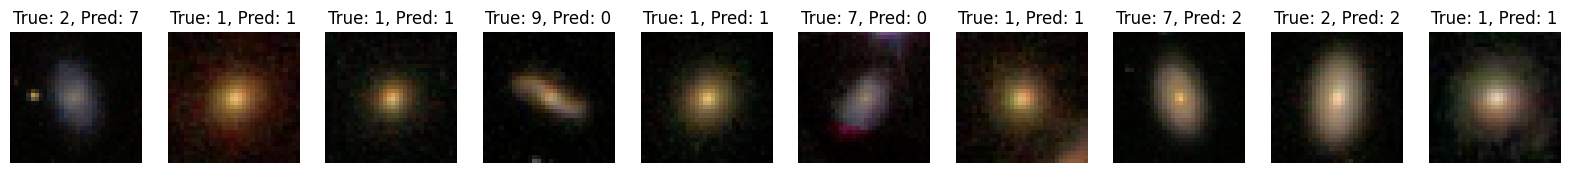

In [ ]:
y_pred = model_deep_cnn.predict(x_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

num_images = 10
plt.figure(figsize=(20, 20))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(x_test[i])
    plt.title(f'True: {y_true_classes[i]}, Pred: {y_pred_classes[i]}')
    plt.axis('off')
plt.show()


# Another deeper CNN

In [ ]:
def another_deeper_cnn():
  # Specify model architecture
  model = Sequential()
  # Block 1
  model.add(Conv2D(16, (6, 6),
                  activation='relu',
                  padding='same',
                  input_shape=(32, 32, 3)))
  model.add(MaxPooling2D((2, 2)))
  # Block 2
  model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.1))
# block 3
  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  # block 4
  model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.1))

  # FC part
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))

  model.add(Dense(10, activation='softmax'))

  # Print summary
  model.summary()

  # Compile model
  model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model_deep_cnn2 = another_deeper_cnn()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 16)          │           1,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 503,482 (1.92 MB)

 Trainable params: 503,482 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Set the number of epochs
NUM_EPOCHS = 40

# Early stopping callback
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# Train the model using the ImageDataGenerator outputs
history3 = model_deep_cnn2.fit(x_train, y_train,
                    validation_split = 0.2,
                    callbacks = [earlystop],
                    epochs = NUM_EPOCHS)

Epoch 1/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.3545 - loss: 1.5898 - val_accuracy: 0.5614 - val_loss: 1.0941
Epoch 2/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - accuracy: 0.5837 - loss: 1.0866 - val_accuracy: 0.6500 - val_loss: 0.9256
Epoch 3/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.6720 - loss: 0.8871 - val_accuracy: 0.6704 - val_loss: 0.8850
Epoch 4/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.6947 - loss: 0.8130 - val_accuracy: 0.6882 - val_loss: 0.8134
Epoch 5/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.7109 - loss: 0.7543 - val_accuracy: 0.6870 - val_loss: 0.7966
Epoch 6/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.7273 - loss: 0.7186 - val_accuracy: 0.7430 - val_loss: 0.7003
Epoch 7/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.7484 - loss: 0.6719 - val_accuracy: 0.7573 - val_loss: 0.6431
Epoch 8/40
436/436 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.7545 - loss: 0.6358 - 

# VGG16

In [ ]:
base_model = VGG16(input_shape=[32,32,3], weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
base_model.trainable = False


In [ ]:
model_vgg = tf.keras.models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_vgg.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,111,242 (57.64 MB)

 Trainable params: 13,965,834 (53.28 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

In [ ]:
adam = optimizers.Adam()
model_vgg.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
history4 = model_vgg.fit(
    train_set,
    validation_data=test_set,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 309s 562ms/step - accuracy: 0.2872 - loss: 2.1808 - val_accuracy: 0.3342 - val_loss: 1.7453
Epoch 2/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 323s 566ms/step - accuracy: 0.3102 - loss: 1.7802 - val_accuracy: 0.3291 - val_loss: 1.7445
Epoch 3/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 303s 556ms/step - accuracy: 0.3218 - loss: 1.7415 - val_accuracy: 0.3027 - val_loss: 1.6981
Epoch 4/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 320s 587ms/step - accuracy: 0.3273 - loss: 1.7063 - val_accuracy: 0.3351 - val_loss: 1.6739
Epoch 5/20
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.3482 - loss: 1.6646

In [ ]:
# Fine tuning of VGG16
# Fine-tuning: Unfreeze some of the last layers of the base model
for layer in base_model.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

# Recompile the model after unfreezing
model_vgg.compile(optimizer=Adam(learning_rate=0.00001),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model with early stopping
history_fine5 = model_vgg.fit(
    train_set,
    validation_data=test_set,
    epochs=10,
    callbacks=[early_stopping]
)

In [ ]:
test_loss, test_acc = model_vgg.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.4f}")

# Resnet

In [ ]:

# Load the pre-trained ResNet50 model (without the top layers)
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32, 3))

# Freeze the layers of ResNet50
base_model_resnet.trainable = False

model_for_Resnet = tf.keras.models.Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_for_Resnet.summary()




In [ ]:
adam = optimizers.Adam()
model_for_Resnet.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_resnet = model_for_Resnet.fit(
    train_set,
    validation_data=test_set,
    epochs=20,
    callbacks=[early_stopping]
)


In [ ]:
# Fine-tuning: Unfreeze some of the last layers of the base model
for layer in base_model_resnet.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

# Recompile the model after unfreezing
model_for_Resnet.compile(optimizer=Adam(learning_rate=0.00001),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model with early stopping
history_fine_res = model_for_Resnet.fit(
    train_set,
    validation_data=test_set,
    epochs=10,
    callbacks=[early_stopping]
)

In [ ]:
test_loss, test_acc =model_for_Resnet.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.4f}")

# EfficientB0

In [ ]:
base_model_efficient =  EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32,32, 3))

base_model_efficient.trainable = False


model_efficient = tf.keras.models.Sequential([
    base_model_efficient,
    GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_efficient.summary()

In [ ]:
model_efficient.summary()

In [ ]:
adam = optimizers.Adam()
model_efficient.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_efficient1 = model_efficient.fit(
    train_set,
    validation_data=test_set,
    epochs=20,
    callbacks=[early_stopping]
)


In [ ]:
# Fine tuning of VGG16
# Fine-tuning: Unfreeze some of the last layers of the base model
for layer in base_model_efficient.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

# Recompile the model after unfreezing
model_efficient.compile(optimizer=Adam(learning_rate=0.00001),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model with early stopping
history_efficient = model_efficient.fit(
    train_set,
    validation_data=test_set,
    epochs=10,
    callbacks=[early_stopping]
)

In [ ]:
test_loss, test_acc = model_efficient.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.4f}")

# Comparison between

In [ ]:
#model performance
def model_performance(model, history, name):
    results = {
        "Model": name,
        "Validation Accuracy": history.history['val_accuracy'][-1] * 100,
        "Validation Loss": history.history['val_loss'][-1],
        "Epochs": len(history.history['accuracy']),
        "Parameters": model.count_params(),
    }
    return results

comparison_data = []

comparison_data.append(model_performance(simple_cnn, history, "Simple CNN"))
comparison_data.append(model_performance(model_deep_cnn, history2, "Deep CNN 1"))
comparison_data.append(model_performance(model_deep_cnn2, history3, "Deep CNN 2"))
comparison_data.append(model_performance(model_vgg, history_fine5, "VGG 16"))
comparison_data.append(model_performance(model_for_Resnet, history_resnet, "Resnet"))
comparison_data.append(model_performance(model_efficient, history_efficient, "Efficient"))

# DataFrame
df = pd.DataFrame(comparison_data)
df

,Model,Validation Accuracy (%),Validation Loss,Epochs,Parameters
0,Simple CNN,76.161790,0.746855,22,422218
1,Deep CNN 1,77.710843,0.616380,14,127434
2,Deep CNN 2,74.182445,0.773019,19,503482
3,VGG 16,32.820749,1.621279,3,15111242
4,Resnet,37.617627,1.582885,20,24770698
5,Efficient,31.489557,1.757716,3,4839341
